In [1]:
import spherical_inr as sph
import torch 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs


In [3]:
hnet = sph.HerglotzNet( 
    output_dim=1,
    inr_sizes = [100] + 3*[100],
    pe_omega0=10.0
)

In [6]:
siren = sph.SirenNet(
    input_dim=2,
    output_dim=1, 
    inr_sizes= [100] + 3*[100],
    first_omega0=10.0
)

In [31]:
def target(theta, phi):
    return torch.sin(3*theta) * torch.cos(5*phi)

In [32]:
# Generate a grid of theta and phi values
theta = torch.linspace(torch.pi/2, -torch.pi/2, 100)
phi = torch.linspace(0, 2 * torch.pi, 100)
theta, phi = torch.meshgrid(theta, phi, indexing='ij')

xtrain = torch.stack([theta, phi], dim=-1).reshape(-1, 2)
ytrain = target(theta, phi).reshape(-1, 1)

In [36]:
num_epochs = 1000
optimizer = torch.optim.Adam(hnet.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    ypred = hnet(xtrain)
    loss = torch.mean((ypred - ytrain)**2)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.5f}")

Epoch 0, Loss 0.25443
Epoch 100, Loss 0.00049
Epoch 200, Loss 0.00021
Epoch 300, Loss 0.00013
Epoch 400, Loss 0.00009
Epoch 500, Loss 0.00006
Epoch 600, Loss 0.00005
Epoch 700, Loss 0.00004
Epoch 800, Loss 0.00003
Epoch 900, Loss 0.00003


In [40]:
num_epochs = 1000
optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    ypred = siren(xtrain)
    loss = torch.mean((ypred - ytrain)**2)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.5f}")

Epoch 0, Loss 1.19378
Epoch 100, Loss 0.00182
Epoch 200, Loss 0.00062
Epoch 300, Loss 0.00033
Epoch 400, Loss 0.00021
Epoch 500, Loss 0.00015
Epoch 600, Loss 0.00011
Epoch 700, Loss 0.00009
Epoch 800, Loss 0.00007
Epoch 900, Loss 0.00006


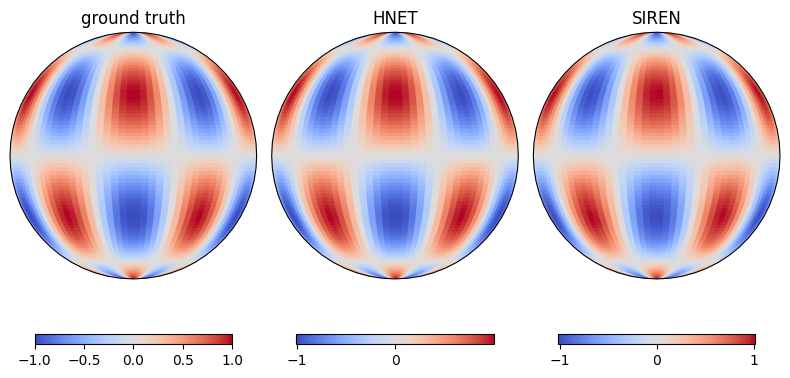

In [46]:
ypred_hnet_plot = hnet(xtrain).detach().numpy().reshape(100, 100)
ypred_siren_plot = siren(xtrain).detach().numpy().reshape(100, 100)
ytrain_plot = ytrain.numpy().reshape(100, 100)

fig = plt.figure(figsize=(8, 4), dpi=100)

ax1 = fig.add_subplot(131, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im1 = ax1.imshow(ytrain_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax1.set_title("ground truth")
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.8)

ax2 = fig.add_subplot(132, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im2 = ax2.imshow(ypred_hnet_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax2.set_title("HNET")
fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.8)

ax3 = fig.add_subplot(133, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
im3 = ax3.imshow(ypred_siren_plot, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
ax3.set_title("SIREN")
fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.8)

plt.tight_layout()
plt.show()